In [1]:
import json
import sqlite3
import pandas as pd
import altair as alt
from utils import percentage_change
from datetime import datetime, timedelta

In [2]:
conn = sqlite3.connect("../db.sqlite3")

In [3]:
buildings = pd.read_sql_query("select * from buildings_building", conn)

In [4]:
sales = pd.read_sql_query("select * from sales_sale", conn)

In [23]:
merged = buildings.merge(sales, left_on="id", right_on="building_id", how="inner").drop(columns=["id_x", "id_y"])

In [24]:
assert len(merged) == len(sales)

Parse the dates

In [25]:
merged.date = pd.to_datetime(merged.date)

Calc the sqft

In [26]:
merged['price_per_square_foot'] = merged.price / merged.square_feet

Cut out junk data

In [39]:
today = datetime.now().today()

In [40]:
this_month = datetime(today.year, today.month, 1)

In [46]:
merged = merged[
    (merged.date.dt.year > 2010)
]

Filter down to our buildings and areas we want to study

In [43]:
pwest = merged[merged.name == 'Promenade West']

In [44]:
bunker_hill = merged[merged.region == 'Bunker Hill']

What are the most recent sales at Promenade West?

In [45]:
pwest.sort_values("date", ascending=False)[[
    'name',
    'date',
    'unit',
    'price',
    'square_feet',
    'price_per_square_foot'
]].head(5)

name       date unit     price  square_feet  \
716  Promenade West 2019-03-04  404  550000.0         1327   
717  Promenade West 2019-01-04  402  580000.0         1327   
718  Promenade West 2018-12-06  416  587000.0         1327   
719  Promenade West 2018-11-26  412  580000.0         1348   
720  Promenade West 2018-07-03  308  620000.0         1323   

     price_per_square_foot  
716             414.468726  
717             437.076112  
718             442.351168  
719             430.267062  
720             468.631897

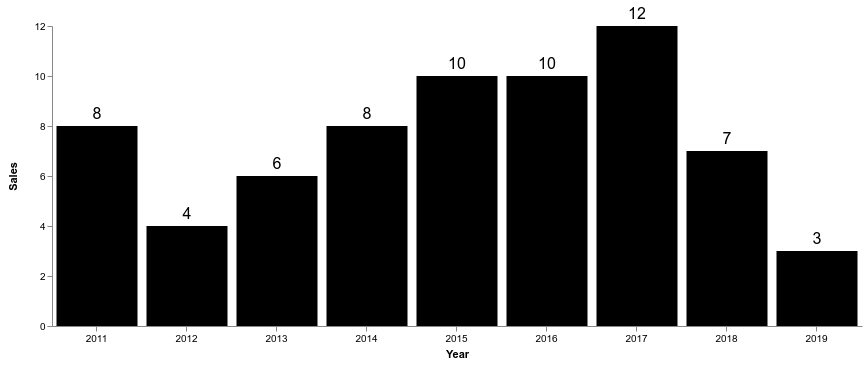

In [31]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        title="Year",
        timeUnit="year",
        axis=alt.Axis(labelAngle=0, title="")
    ),
    y=alt.Y(
        "count()",
        title="Sales",
        axis=alt.Axis(title="", grid=False)
    )
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-12,
    size=16
).encode(text='count()')

(bars + text).configure_view(
    strokeOpacity=0
)

### Prices by date

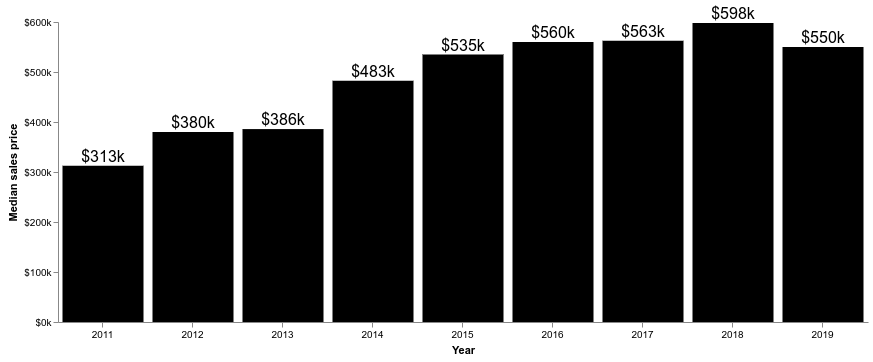

In [32]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="Year", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="Median sales price", format="$s", grid=False),
    ),
)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=16,
).encode(
    text=alt.Text('median(price):Q', format="$.3s")
)

(bars + text).configure_view(
    strokeOpacity=0
)

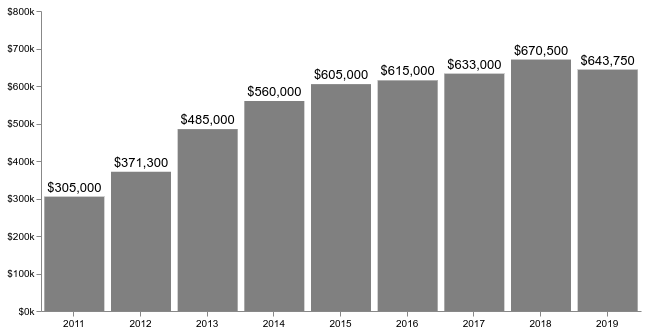

In [33]:
bars = alt.Chart(merged).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750000]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price):Q', format="$,.0f")
)

(bars + text).configure_view(
    strokeOpacity=0
)

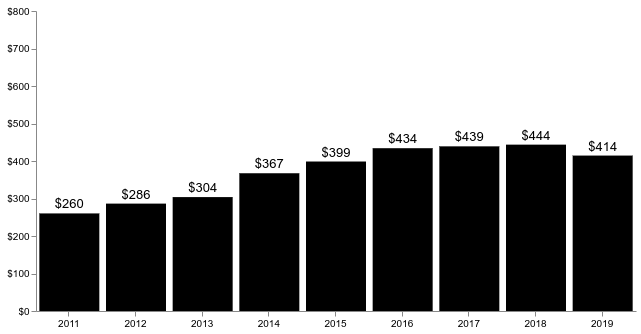

In [34]:
bars = alt.Chart(pwest).mark_bar(color="black").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

(bars + text).configure_view(
    strokeOpacity=0
)

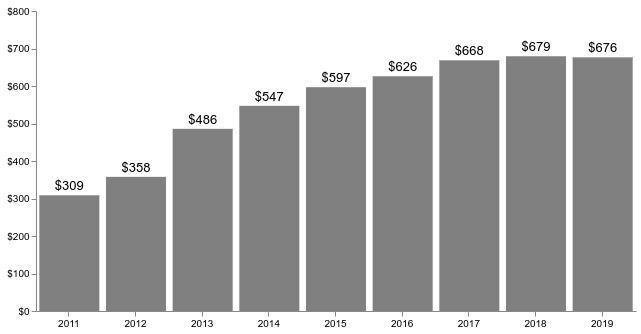

In [54]:
bars = alt.Chart(merged[merged.date < this_month]).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="year",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

(bars + text).configure_view(
    strokeOpacity=0
)

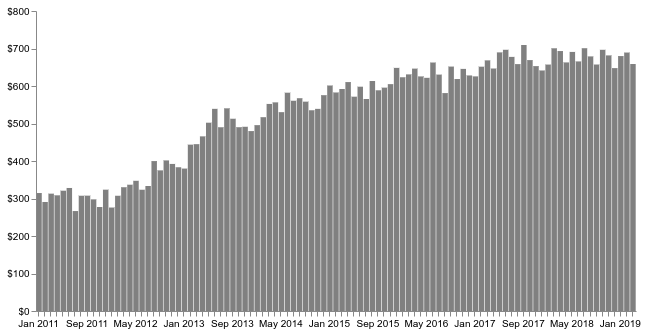

In [48]:
bars = alt.Chart(merged[merged.date < this_month]).mark_bar(color="gray").encode(
    x=alt.X(
        "date:O",
        timeUnit="yearmonth",
        axis=alt.Axis(title="", labelAngle=0),
    ),
    y=alt.Y(
        "median(price_per_square_foot):Q",
        axis=alt.Axis(title="", format="$s", grid=False),
        scale=alt.Scale(domain=[0, 750]),
    ),
).properties(width=600)

text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=-9,
    size=13
).encode(
    text=alt.Text('median(price_per_square_foot):Q', format="$,.0f")
)

(bars).configure_view(
    strokeOpacity=0
)

## Bunker Hill

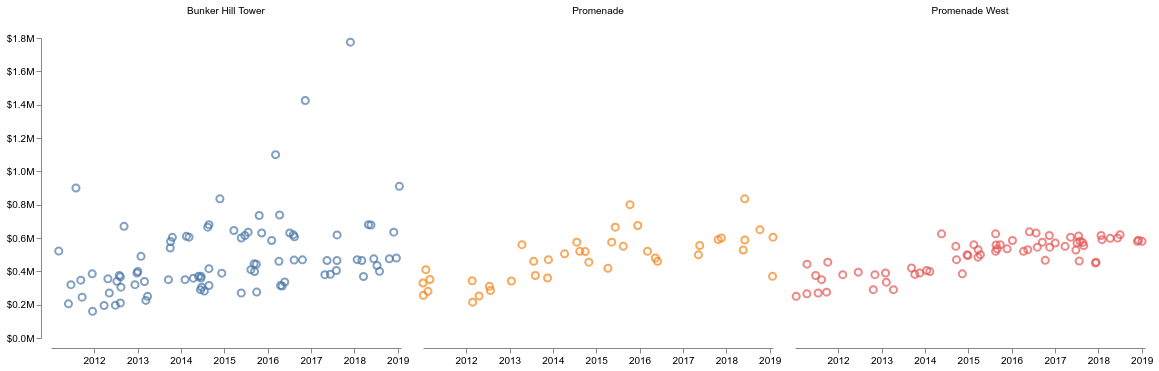

In [22]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color=alt.Color("building_name:N", legend=None),
    column=alt.Column("building_name", title=""),
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=350).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/bunker-hill-price-by-date.svg')

chart

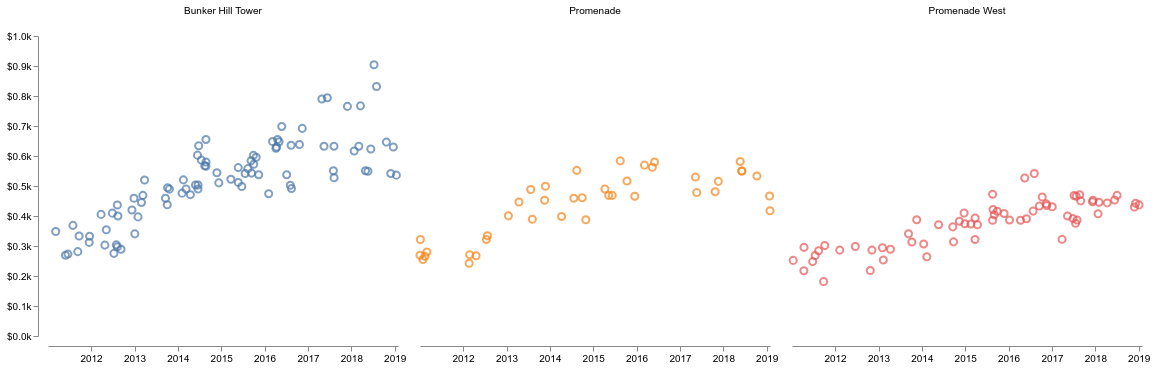

In [23]:
chart = alt.Chart(bunker_hill).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False)
    ),
    color=alt.Color("building_name:N", legend=None, title=""),
    column=alt.Column("building_name", title=""),
    tooltip=["building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=350).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/bunker-hill-price-per-sqft-by-date.svg')

chart

## Region

In [24]:
# chart = alt.Chart(df).mark_line().encode(
#     x=alt.X(
#         "date:T",
#         timeUnit="yearmonth",
#         axis=alt.Axis(title="", labelAngle=0, format="%Y"),
#     ),
#     y=alt.Y(
#         "median(price):Q",
#         axis=alt.Axis(title="", format="$s"),
#     ),
# ).properties(width=600).configure_view(
#     strokeOpacity=0
# )

# if SAVE_CHARTS:
#     chart.save('assets/price-by-year.svg')

# chart

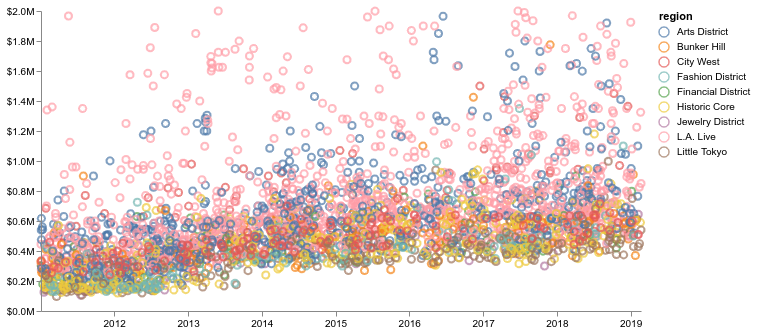

In [25]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", grid=False),
    ),
    y=alt.Y(
        "price:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    #column=alt.Column("region", sort=alt.SortField(field="price", op="median", order="descending")),
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).transform_filter(
    alt.datum.price <= 2000000
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-date.svg')

chart

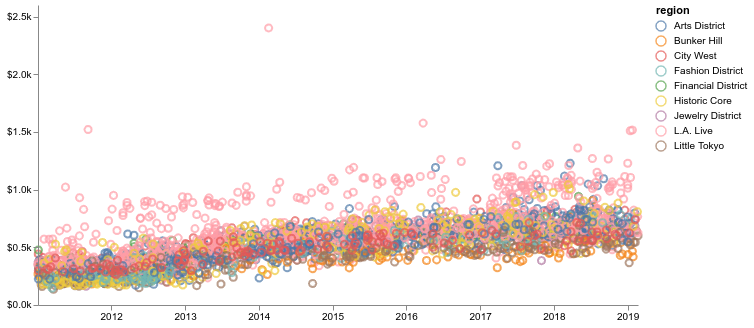

In [26]:
chart = alt.Chart(df).mark_point(size=50).encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(title="", format="%Y", tickCount=7, grid=False),
    ),
    y=alt.Y(
        "price_per_square_foot:Q",
        axis=alt.Axis(title="", format="$s", grid=False),
    ),
    color="region",
    tooltip=["region", "building_name", "unit", "price", "square_feet", "price_per_square_foot"]
).properties(width=600).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/price-by-date.svg')

chart

## Last 12 months

In [27]:
one_year_ago = datetime.now() - timedelta(days=365)

In [28]:
last_year = df[df.date > one_year_ago]

In [29]:
last_year.groupby(["region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

price  square_feet  unit  price_per_square_foot
region                                                                
Fashion District    555000.0        750.0     7             761.538462
Financial District  595000.0        850.0     9             724.275724
Jewelry District    537500.0        765.0    12             719.230769
L.A. Live           790000.0       1170.0   153             705.696203
Arts District       792000.0       1179.0    72             700.975930
Historic Core       545000.0        800.0    37             687.500000
City West           555000.0        960.0    31             662.500000
Little Tokyo        475875.0        910.0    40             556.068376
Bunker Hill         587000.0       1219.0    23             549.432739

In [30]:
last_year.groupby(["building_name", "region"]).agg({
    "unit": "count",
    "price": "median",
    "price_per_square_foot": "median",
    "square_feet": "median",
}).sort_values("price_per_square_foot", ascending=False)

price  square_feet  unit  \
building_name           region                                             
Metropolis Tower II     L.A. Live            900000.0        787.0     6   
Metropolis Tower I      L.A. Live            698000.0        760.0     7   
Ritz Carlton            L.A. Live           1825000.0       1718.0    17   
Biscuit Company Lofts   Arts District       1229000.0       1189.0     7   
Ten50                   L.A. Live           1232250.0       1256.0    10   
Gallery Lofts           Arts District        736000.0        866.0     3   
The Rowan               Historic Core        642500.0        765.0    10   
Barker Block Warehouse  Arts District        870000.0       1092.0     3   
Santee Village: Cornell Fashion District     540000.0        700.0     2   
Eastern Columbia        L.A. Live           1225000.0       1610.0     9   
Toy Factory             Arts District       1072500.0       1464.0    10   
Textile Building        Fashion District     555000.0        890.0     5   
Concerto Lofts          L.A. Live            677500.0        925.0     6   
655 Hope                Financial District   725000.0       1001.0     7   
Douglas                 Historic Core        652500.0        905.0     2   
Bartlett                Jewelry District     537500.0        765.0    12   
El Dorado               Historic Core        730000.0       1020.0     3   
Library Court           Financial District   490000.0        685.0     2   
Luma Lofts              L.A. Live            651500.0        930.0    12   
Beacon Lofts            Arts District        747250.0       1065.0     2   
110 Wilshire            City West            532000.0        800.0    13   
Barker Block Lofts      Arts District        870000.0       1380.0    13   
Evo                     L.A. Live            707500.0       1120.0    24   
Sky Lofts               L.A. Live            880000.0       1320.0    11   
940 E. 2nd Street       Arts District       1650000.0       2453.0     1   
Skyline                 L.A. Live            535000.0        754.0     9   
Mura                    Arts District        803500.0       1240.0    14   
Toy Warehouse           Arts District       1207500.0       1869.0     2   
Pan American            Historic Core        705000.0       1100.0     3   
Savoy                   Arts District        592500.0        910.0    13   
Bunker Hill Tower       Bunker Hill          475000.0        762.0    11   
Market Lofts            L.A. Live            655000.0       1036.5    18   
Higgins                 Historic Core        525000.0        800.0     7   
Shy Barry Grand         Historic Core        470000.0        800.0    12   
Vero                    City West            595000.0        975.0    18   
Elleven Lofts           L.A. Live            610000.0       1070.0    17   
Grand Lofts             L.A. Live            974999.5       1648.5     2   
Little Tokyo Lofts      Little Tokyo         516000.0        890.0    21   
Molino Street Lofts     Arts District        997500.0       1800.0     4   
Tokyo Villa             Little Tokyo         450000.0        848.0     9   
Promenade               Bunker Hill          596500.0       1144.0     6   
Flower Street Lofts     L.A. Live            711000.0       1424.0     5   
Teramachi               Little Tokyo         483375.0        970.0    10   
Promenade West          Bunker Hill          592500.0       1327.0     6   

                                            price_per_square_foot  
building_name           region                                     
Metropolis Tower II     L.A. Live                     1171.489438  
Metropolis Tower I      L.A. Live                     1105.461394  
Ritz Carlton            L.A. Live                     1061.138440  
Biscuit Company Lofts   Arts District                 1033.641716  
Ten50                   L.A. Live                      967.536670  
Gallery Lofts           Arts District                  837.182448  
The Row

## Largest units

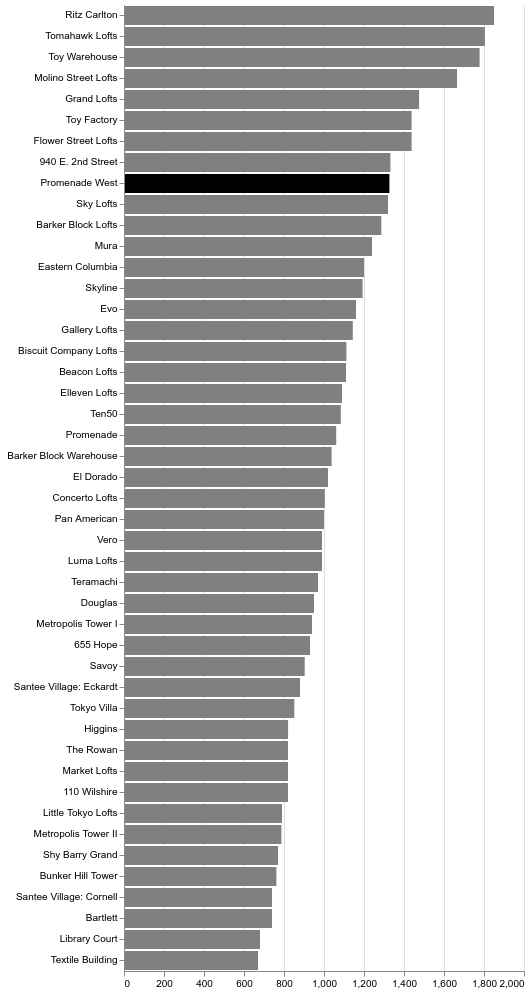

In [31]:
chart = alt.Chart(df).mark_bar().encode(
    x=alt.X(
        "median(square_feet):Q",
        axis=alt.Axis(title="")
    ),
    y=alt.Y(
        "building_name:N",
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="square_feet", op="median", order="descending")
    ),
    color=alt.condition(
        alt.datum.building_name == 'Promenade West',
        alt.value("black"),
        alt.value("gray")
    )
).configure_view(
    strokeOpacity=0
)

if SAVE_CHARTS:
    chart.save('assets/size-by-building.svg')

chart